# Ejercicio 2 

In [316]:
import matplotlib.pyplot as plt

In [317]:
import numpy as np

In [522]:
from skimage import filters

In [523]:
from skimage import morphology

In [318]:
import cv2

## Cargando la imagen

In [462]:
image_original = cv2.imread('../resources/eyebw.jpg', cv2.IMREAD_GRAYSCALE)

## Visualizando la imagen

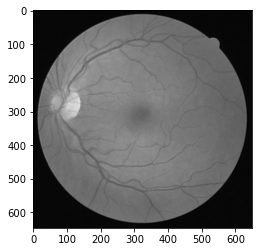

In [320]:
plt.imshow(image_original, cmap='gray', vmin=0, vmax=255)

## Transformaciones

In [400]:
def apply_transformation(transformation, image):
    """ Apply a transformation function to all pixel of the given image
        @param transformation Transformation s = T(r)
        @param image Input image to be transformed
        @return Output image after transformation
    """
    return np.array(list(map(np.vectorize(transformation), image)), dtype=np.uint8)

In [401]:
def black_and_white(threshold, max_value, input_pixel):
    """ Apply a transformation to the input pixel intensity to transform it into white or black
        according to the given threshold.
        @param threshold Threshold to separate where the pixel becomes black or white
        @param max_value Maximum value of the intensity scale
        @param input_pixel Intensity of the input pixel
        @return Intensity of the output pixel
    """
    return max_value if input_pixel > threshold else 0

In [402]:
def negative(max_value, input_pixel):
    """ Apply a transformation to get the negative version of the pixel.
        @param max_value Maximum value of the intensity scale
        @param input_pixel Intensity of the input pixel
        @return Intensity of the output pixel
    """
    return max_value - 1 - input_pixel

In [403]:
def logaritmic(coefficient, max_value, input_pixel):
    """ Apply a transformation to a logaritmic scale.
        @param coefficient Used to define the transformation
        @param max_value Maximum value of the intensity scale
        @param input_pixel Intensity of the input pixel
        @return Intensity of the output pixel
    """
    return coefficient * np.log10(1 + input_pixel / max_value)

In [792]:
def exponential_logaritmic(coefficient, gamma, max_value, input_pixel):
    """ Apply an exponential logaritmic transformation
        @param coefficient Used to define the transformation
        @param gamma Gamma parameter
        @param max_value Maximum value of the intensity scale
        @param input_pixel Intensity of the input pixel
        @return Intensity of the output pixel
    """
    return coefficient * ((input_pixel / max_value) ** gamma)

### Transformación negativa

In [945]:
image_negative = apply_transformation(lambda r: negative(255, r), image_original)

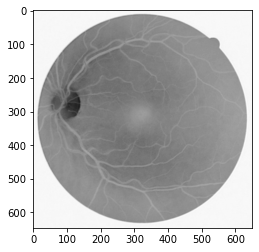

In [954]:
plt.imshow(image_negative, cmap='gray', vmin=0, vmax=255)

### Ecualización por histograma

In [955]:
pdf, bins = np.histogram(image_negative.flatten(), bins=image_negative.max()-image_negative.min(), density=True)

In [956]:
cdf = np.cumsum(pdf)

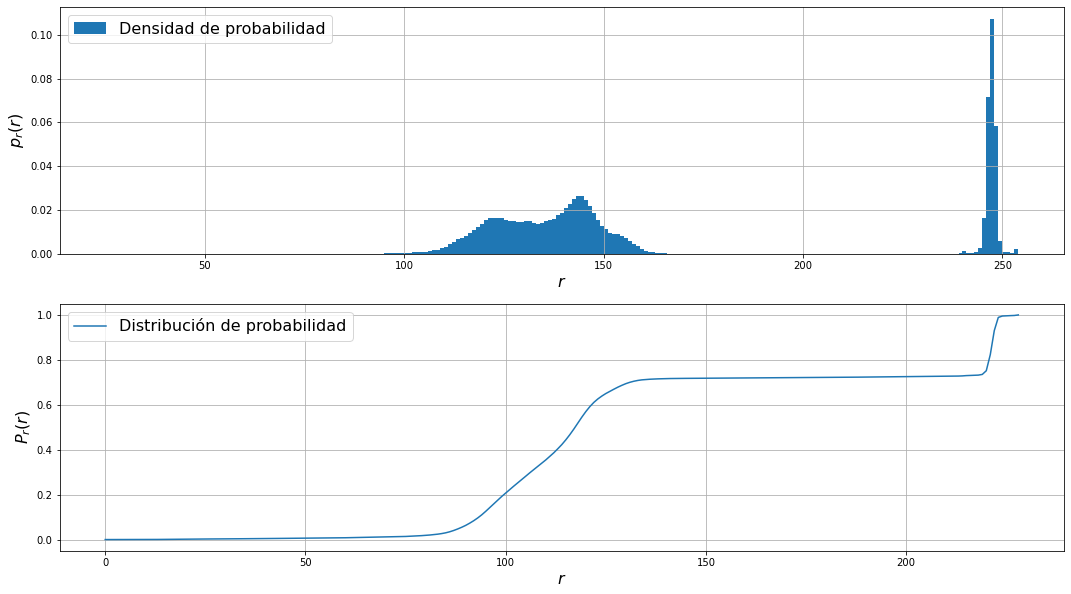

In [957]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

ax1.bar(bins[:-1]+0.5, pdf, width=1.0, label='Densidad de probabilidad')
ax1.set_xlabel('$r$', fontsize=16)
ax1.set_ylabel('$p_r(r)$', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid()

ax2.plot(cdf, label='Distribución de probabilidad')
ax2.set_xlabel('$r$', fontsize=16)
ax2.set_ylabel('$P_r(r)$', fontsize=16)
ax2.legend(fontsize=16)
ax2.grid()

plt.show()

En primer lugar, es necesario aclarar que si bien las leyendas de los gráficos presentados dicen *densidad de probabilidad* y *distribución de probabilidad*. En realidad, son estimaciones de tales parámetros estadísticos de la imagen. En segundo lugar, se observa que la imagen tiene una fuerte densidad en las altas intensidades, esto se puede atribuir a la presencia del fondo blanco en la imagen. Entonces, la densidad en el intervalo $(100, 150)$ describe una imagen de bajo contraste, y justamente el hecho de que no se esté aprovechando adecuadamente el rango completo es causa de la mala calidad que se percibe en la imagen.

Para corregir esto, es necesario aplicar una transformación para aprovechar todo el rango dinámico, para lo cual puede ser útil emplear como transformación la distribución de probabilidad estimada. No obstante, la presencia del fondo provoca que la imagen sólo pueda ser mapeada a aproximadamente un 70% del rango. Por esto, se busca remover del histograma las bajas intensidades.

In [958]:
pdf_preprocessed = np.zeros(256)
pdf_preprocessed[image_negative.min():image_negative.max()] = pdf
pdf_preprocessed[200:] = 0
pdf_preprocessed /= pdf_preprocessed.sum()
cdf_preprocessed = np.cumsum(pdf_preprocessed)

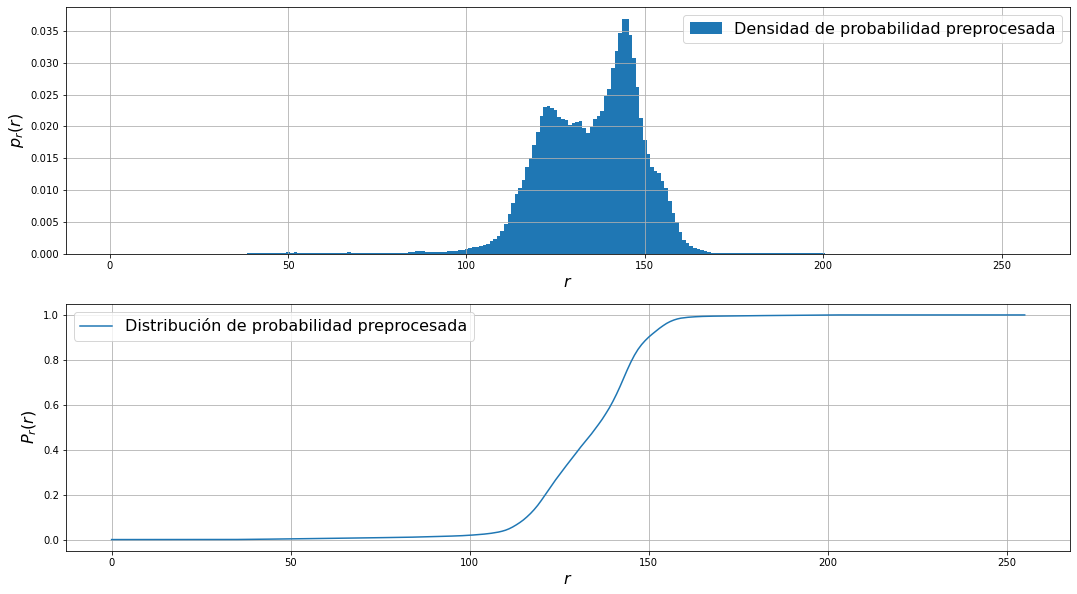

In [959]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

ax1.bar(np.linspace(1, 256, 256), pdf_preprocessed, width=1.0, label='Densidad de probabilidad preprocesada')
ax1.set_xlabel('$r$', fontsize=16)
ax1.set_ylabel('$p_r(r)$', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid()

ax2.plot(cdf_preprocessed, label='Distribución de probabilidad preprocesada')
ax2.set_xlabel('$r$', fontsize=16)
ax2.set_ylabel('$P_r(r)$', fontsize=16)
ax2.legend(fontsize=16)
ax2.grid()

plt.show()

In [985]:
image_negative_equalize = apply_transformation(lambda r: cdf_preprocessed[r - 1] * 200, image_negative)

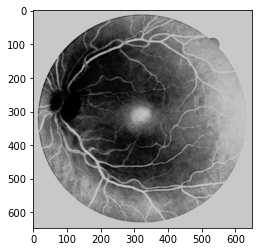

In [986]:
plt.imshow(image_negative_equalize, cmap='gray', vmin=0, vmax=255)

### Transformación negativa

In [1075]:
image_negative_equalize_negative = apply_transformation(lambda r: negative(255, r), image_negative_equalize)

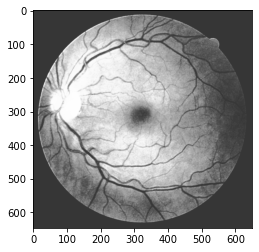

In [1076]:
plt.imshow(image_negative_equalize_negative, cmap='gray', vmin=0, vmax=255)

## Transformación exponencial logarítmica

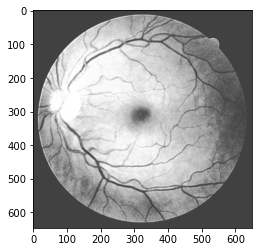

In [1104]:
image_negative_equalize_negative_exp = apply_transformation(lambda r: exponential_logaritmic(512, 0.3, 255, r), image_negative_equalize_negative)
plt.imshow(image_negative_equalize_negative_exp, cmap='gray', vmin=0, vmax=255)

## High Boost

In [1105]:
kernel = -np.ones((3, 3))
kernel[1,1] = 9.0

In [1106]:
image_negative_equalize_negative_exp_boost = cv2.filter2D(image_negative_equalize_negative_exp, -1, kernel)

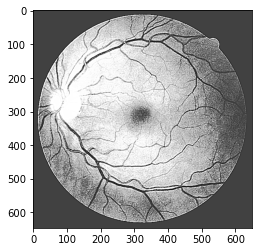

In [1107]:
plt.imshow(image_negative_equalize_negative_exp_boost, cmap='gray', vmin=0, vmax=255)

# Resultado

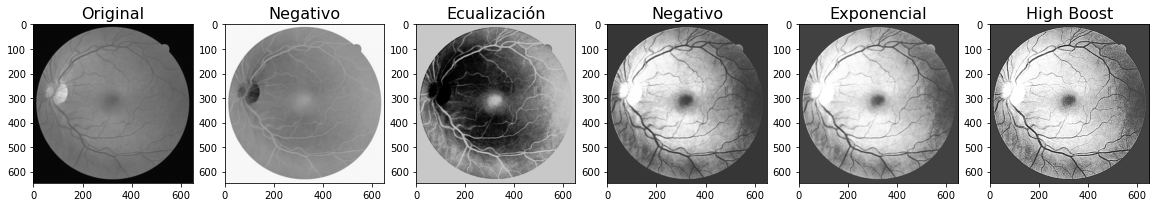

In [1114]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))

ax1.imshow(image_original, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Original', fontsize=16)

ax2.imshow(image_negative, cmap='gray', vmin=0, vmax=255)
ax2.set_title('Negativo', fontsize=16)

ax3.imshow(image_negative_equalize, cmap='gray', vmin=0, vmax=255)
ax3.set_title('Ecualización', fontsize=16)

ax4.imshow(image_negative_equalize_negative, cmap='gray', vmin=0, vmax=255)
ax4.set_title('Negativo', fontsize=16)

ax5.imshow(image_negative_equalize_negative_exp, cmap='gray', vmin=0, vmax=255)
ax5.set_title('Exponencial', fontsize=16)

ax6.imshow(image_negative_equalize_negative_exp_boost, cmap='gray', vmin=0, vmax=255)
ax6.set_title('High Boost', fontsize=16)

plt.show()

## Comentarios finales
En primer lugar, se buscó observar cómo era el histograma de la imagen para identificar si efectivamente la mala calidad provenía de un mal uso del rango dinámico, y por ende, un mal contraste en la misma. Se realizó la **ecualización** de la imagen, pero se llegó a la conclusión (de forma empírica, a prueba y error) que era mejor trabajar con la versión **negativa** para realizar tal ecualización. Se utilizó una transformación **exponencial**, para remover regiones que poseen bajo contraste con las venas. Finalmente, se aplico un filtrado **high boost** para enfatizar y remarcar los bordes, aumentando la calidad percibida de la imagen y remarcando las venas.

Es de interés notar que, la ecualización no termina utilizando todo el rango dinámico. Esto se debe a que en ciertas regiones hay intensidades similares a las de las venas, con lo cual esas zonas presentan un bajo contraste. Se descubrió que si no se usaba todo el rango y se aplicaba una transformación exponencial, se lograba remover parcialmente estas regiones, al punto de distinguir a simple vista todas las venas, aunque estuvieran inmersas en estas nubes semi uniformes.

Se probaron otros métodos para remover las regiones manchadas que tienen un bajo contraste con las venas, como el filtrado no lineal de mediana, paro no se obtuvieron resultados prometedores.